In [1]:
import sys
import os
sys.path.append('../')

from tqdm import tqdm

import pandas as pd
from PIL import Image, ImageOps
from tqdm import tqdm
from glob import glob

#Base on https://github.com/aosokin/os2d github and annotation

In [2]:
!wget 'https://drive.usercontent.google.com/download?id=1Fx9lvmjthe3aOqjvKc6MJpMuLF22I1Hp&export=download&authuser=1&confirm=t' -O grozi.zip 

--2025-01-21 11:24:30--  https://drive.usercontent.google.com/download?id=1Fx9lvmjthe3aOqjvKc6MJpMuLF22I1Hp&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 216.58.214.65, 2a00:1450:4007:807::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|216.58.214.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591989308 (565M) [application/octet-stream]
Saving to: ‘grozi.zip’

grozi.zip           100%[===================>] 564,56M  5,56MB/s    in 1m 41s  

2025-01-21 11:26:12 (5,60 MB/s) - ‘grozi.zip’ saved [591989308/591989308]



In [3]:
!wget 'https://drive.usercontent.google.com/download?id=1Vp8sm9zBOdshYvND9EPuYIu0O9Yo346J&export=download&authuser=1&confirm=t' -O retail_test_sets.zip


--2025-01-21 11:26:12--  https://drive.usercontent.google.com/download?id=1Vp8sm9zBOdshYvND9EPuYIu0O9Yo346J&export=download&authuser=1&confirm=t
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 216.58.214.65, 2a00:1450:4007:807::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|216.58.214.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100155281 (96M) [application/octet-stream]
Saving to: ‘retail_test_sets.zip’

retail_test_sets.zi 100%[===================>]  95,51M  5,56MB/s    in 17s     

2025-01-21 11:26:31 (5,78 MB/s) - ‘retail_test_sets.zip’ saved [100155281/100155281]



In [4]:
!unzip retail_test_sets.zip
!unzip grozi.zip

Archive:  retail_test_sets.zip
   creating: dairy/
   creating: dairy/classes/
  inflating: dairy/classes/.~lock.dairy.csv#  
  inflating: dairy/classes/dairy.csv  
   creating: dairy/classes/images/
  inflating: dairy/classes/images/114.jpg  
  inflating: dairy/classes/images/29.jpg  
  inflating: dairy/classes/images/155.jpg  
  inflating: dairy/classes/images/34.jpg  
  inflating: dairy/classes/images/127.jpg  
  inflating: dairy/classes/images/90.jpg  
  inflating: dairy/classes/images/153.jpg  
  inflating: dairy/classes/images/163.jpg  
  inflating: dairy/classes/images/86.jpg  
  inflating: dairy/classes/images/17.jpg  
  inflating: dairy/classes/images/64.jpg  
  inflating: dairy/classes/images/133.jpg  
  inflating: dairy/classes/images/120.jpg  
  inflating: dairy/classes/images/59.jpg  
  inflating: dairy/classes/images/67.jpg  
  inflating: dairy/classes/images/57.jpg  
  inflating: dairy/classes/images/135.jpg  
  inflating: dairy/classes/images/13.jpg  
  inflating: dairy

In [5]:
paths = ['images',
         'images/train',
         'images/test',
         'images/valid',
         'images/dairy',
         'images/paste',
         'labels',
         'labels/train',
         'labels/test',
         'labels/valid',
         'labels/dairy',
         'labels/paste',
         'supports',
         ]

for path in paths:
    if not os.path.exists(path):
        os.mkdir(path)


In [6]:
p1 = pd.read_csv("dairy/classes/dairy.csv")
p1.head()


,gtbboxid,classid,imageid,lx,rx,ty,by,difficult
0,899,0,0,0.0007,0.0169,0.1784,0.4371,1
1,900,0,0,0.0189,0.0980,0.1733,0.4345,0
2,428,1,4,0.7875,0.8250,0.1098,0.2586,1
3,429,1,4,0.8213,0.8712,0.1113,0.2602,0
4,430,1,0,0.0885,0.1601,0.1853,0.4500,0


In [7]:
p2 = pd.read_csv("paste/classes/paste.csv")
p2.head()

,gtbboxid,classid,imageid,lx,rx,ty,by,difficult
0,0,3543,16454,0.0351,0.0785,0.0324,0.1354,0
1,1,3543,16454,0.0728,0.1178,0.0336,0.1362,0
2,2,3543,16454,0.1105,0.1508,0.0309,0.1346,0
3,3,3552,16454,0.1451,0.1921,0.0324,0.1381,0
4,4,3552,16454,0.1854,0.2335,0.0336,0.1373,0


In [8]:
p3 = pd.read_csv("grozi/classes/grozi.csv")
p3.head()

,gtbboxid,classid,imageid,lx,rx,ty,by,difficult,split
0,0,0,0,0.1075,0.2350,0.0000,0.2433,0,train
1,1,0,0,0.2350,0.3775,0.0000,0.2500,0,train
2,2,1,0,0.3900,0.5250,0.0033,0.2700,0,train
3,3,1,0,0.5200,0.6500,0.0200,0.2700,0,train
4,4,1,0,0.6450,0.7650,0.0467,0.2733,0,train


In [9]:
def resize_with_padding(img, expected_size, colors=(114,114,114)):
    width, height = img.size
    ratio = width / height
    if width < height:
        img = img.resize((int(ratio*expected_size[0]),int(expected_size[0])))
    else:
        img = img.resize((int(expected_size[1]),int((1/ratio)*expected_size[1])))
        
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, colors)

In [10]:
def resize_label_with_padding(old_size, expected_size, bbox):
    (x,y,w,h) = bbox

    ratio = old_size[0] / old_size[1]
    if old_size[0] < old_size[1]:
        new = (int(ratio*expected_size[0]),int(expected_size[0]))
    else:
        new = (int(expected_size[1]),int((1/ratio)*expected_size[1]))

    delta_width = expected_size[0] - new[0]
    delta_height = expected_size[1] - new[1]

    pad_width = delta_width // 2
    pad_height = delta_height // 2

    x_t = (pad_width +  (x)*new[0]) / expected_size[0]
    y_t = (pad_height + (y)*new[1]) / expected_size[1]
    w_t = w*new[0] / expected_size[0]
    h_t = h*new[1] / expected_size[1]
    
    return x_t,y_t,w_t,h_t

In [11]:
changement = {}
i = 0

# support
for classid in tqdm(p3['classid'].unique()):
    image = Image.open("grozi/classes/images/"+str(classid)+".jpg")
    image = resize_with_padding(image,(160,160),(0,0,0))
    changement[classid] = i
    if not os.path.exists('supports/'+str(i)):
        os.mkdir('supports/'+str(i))    
    image.save("supports/"+str(changement[classid])+'/0.png')
    i = i + 1

100%|██████████| 1063/1063 [00:06<00:00, 157.61it/s]


In [12]:
d = p3.loc[p3['split'] == 'train']

y = 0

for imageid in tqdm(d['imageid'].unique()):
    path_img = "images/train/"
    path_lab = "labels/train/"
    image = Image.open("grozi/src/3264/"+str(imageid)+".jpg")
    width,height = image.size
    image = resize_with_padding(image,(640,640)) #max
    image.save(path_img+str(y)+'.png')
    m = d.loc[d['imageid'] == imageid]
    with open(path_lab+str(y)+'.txt', 'wt') as f:
        # [box_left, box_top, box_right, box_bottom], 1) # lx ty rx by
        for c, lx, rx, ty, by in m[['classid','lx',	'rx','ty','by']].iloc(): 
            cx = (lx + rx) /2
            cy = (ty + by) / 2
            w = rx - lx
            h = by - ty

            cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h)) #max
            s = str(changement[c])+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
            f.write(s)
    y = y + 1

100%|██████████| 596/596 [02:10<00:00,  4.58it/s]


In [13]:
d = p3.loc[p3['split'] == 'val-old-cl']

y = 0

for imageid in tqdm(d['imageid'].unique()):
    path_img = "images/valid/"
    path_lab = "labels/valid/" 
    image = Image.open("grozi/src/3264/"+str(imageid)+".jpg")
    width,height = image.size
    image = resize_with_padding(image,(640,640)) #max
    image.save(path_img+str(y)+'.png')
    m = d.loc[d['imageid'] == imageid]
    with open(path_lab+str(y)+'.txt', 'wt') as f:
        for c,lx,rx,ty,by in m[['classid','lx',	'rx',	'ty',	'by']].iloc(): # [box_left, box_top, box_right, box_bottom], 1) # lx ty rx by
            cx = (rx + lx) /2
            cy = (by + ty) / 2
            w = rx - lx
            h = by - ty
            cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h)) #max
            s = str(changement[c])+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
            f.write(s)
    y = y + 1

100%|██████████| 60/60 [00:12<00:00,  4.78it/s]


In [14]:
d = p3.loc[p3['split'] == 'val-new-cl']

y = 0

for imageid in tqdm(d['imageid'].unique()):
    path_img = "images/test/"
    path_lab = "labels/test/" 
    image = Image.open("grozi/src/3264/"+str(imageid)+".jpg")
    width,height = image.size
    image = resize_with_padding(image,(640,640)) #max
    image.save(path_img+str(y)+'.png')
    m = d.loc[d['imageid'] == imageid]
    with open(path_lab+str(y)+'.txt', 'wt') as f:
        for c,lx,rx,ty,by in m[['classid','lx',	'rx',	'ty',	'by']].iloc(): # [box_left, box_top, box_right, box_bottom], 1) # lx ty rx by
            cx = (rx + lx) /2
            cy = (by + ty) / 2
            w = rx - lx
            h = by - ty
            cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h)) #max
            s = str(changement[c])+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
            f.write(s)
    y = y + 1

100%|██████████| 84/84 [00:17<00:00,  4.77it/s]


In [15]:
# Dairy datasets add
changement = {}

for classid in tqdm(p1['classid'].unique()):
    image = Image.open("dairy/classes/images/"+str(classid)+".jpg")
    image = resize_with_padding(image,(160,160),(0,0,0))
    changement[classid] = i
    if not os.path.exists('supports/'+str(i)):
        os.mkdir('supports/'+str(i))  
    image.save("supports/"+str(changement[classid])+'/0.png')
    i = i + 1

d = p1

y = 0

for imageid in tqdm(d['imageid'].unique()):
    path_img = "images/dairy/"
    path_lab = "labels/dairy/" 
    image = Image.open("dairy/src/original/"+str(imageid)+".jpg")
    width,height = image.size
    image = resize_with_padding(image,(640,640)) #max
    image.save(path_img+str(y)+'.png')
    m = d.loc[d['imageid'] == imageid]
    with open(path_lab+str(y)+'.txt', 'wt') as f:
        for c,lx,rx,ty,by in m[['classid','lx',	'rx',	'ty',	'by']].iloc(): # [box_left, box_top, box_right, box_bottom], 1) # lx ty rx by
            cx = (rx + lx) /2
            cy = (by + ty) / 2
            w = rx - lx
            h = by - ty
            cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h)) #max
            s = str(changement[c])+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
            f.write(s)
    y = y + 1

100%|██████████| 12/12 [00:03<00:00,  3.53it/s]


In [16]:
# For paste Datasets

changement = {}

for classid in tqdm(p2['classid'].unique()):
    image = Image.open("paste/classes/images/"+str(classid)+".jpg")
    image = resize_with_padding(image,(160,160),(0,0,0))
    changement[classid] = i
    if not os.path.exists('supports/'+str(i)):
        os.mkdir('supports/'+str(i))  
    image.save("supports/"+str(changement[classid])+'/0.png')
    i = i + 1

d = p2

y = 0

for imageid in tqdm(d['imageid'].unique()):
    path_img = "images/paste/"
    path_lab = "labels/paste/" 
    image = Image.open("paste/src/original/"+str(imageid)+".jpg")
    width,height = image.size
    image = resize_with_padding(image,(640,640)) #max
    image.save(path_img+str(y)+'.png')
    m = d.loc[d['imageid'] == imageid]
    with open(path_lab+str(y)+'.txt', 'wt') as f:
        for c,lx,rx,ty,by in m[['classid','lx',	'rx',	'ty',	'by']].iloc(): # [box_left, box_top, box_right, box_bottom], 1) # lx ty rx by
            cx = (rx + lx) /2
            cy = (by + ty) / 2
            w = rx - lx
            h = by - ty
            cx,cy,w,h = resize_label_with_padding((width,height), (640,640), (cx,cy,w,h)) #max
            s = str(changement[c])+' '+str(cx)+' '+str(cy)+' '+str(w)+' '+str(h)+' \n'
            f.write(s)
    y = y + 1

100%|██████████| 91/91 [00:11<00:00,  8.04it/s]


In [17]:
with open('data.yaml', 'wt') as f:
    f.write('train: images/train \n')
    f.write('val: images/valid \n')
    f.write('test: images/test \n')
    f.write('dairy: images/dairy \n')
    f.write('paste: images/paste \n')
    f.write('support: supports \n')
    f.write(' \n')
    f.write('nc: '+str(i)+'\n')

In [18]:
!rm -rf dairy

In [19]:
!rm -rf grozi

In [20]:
!rm -rf paste

In [21]:
!rm grozi.zip

In [22]:
!rm retail_test_sets.zip

100%|██████████| 84/84 [00:00<00:00, 39591.14it/s]


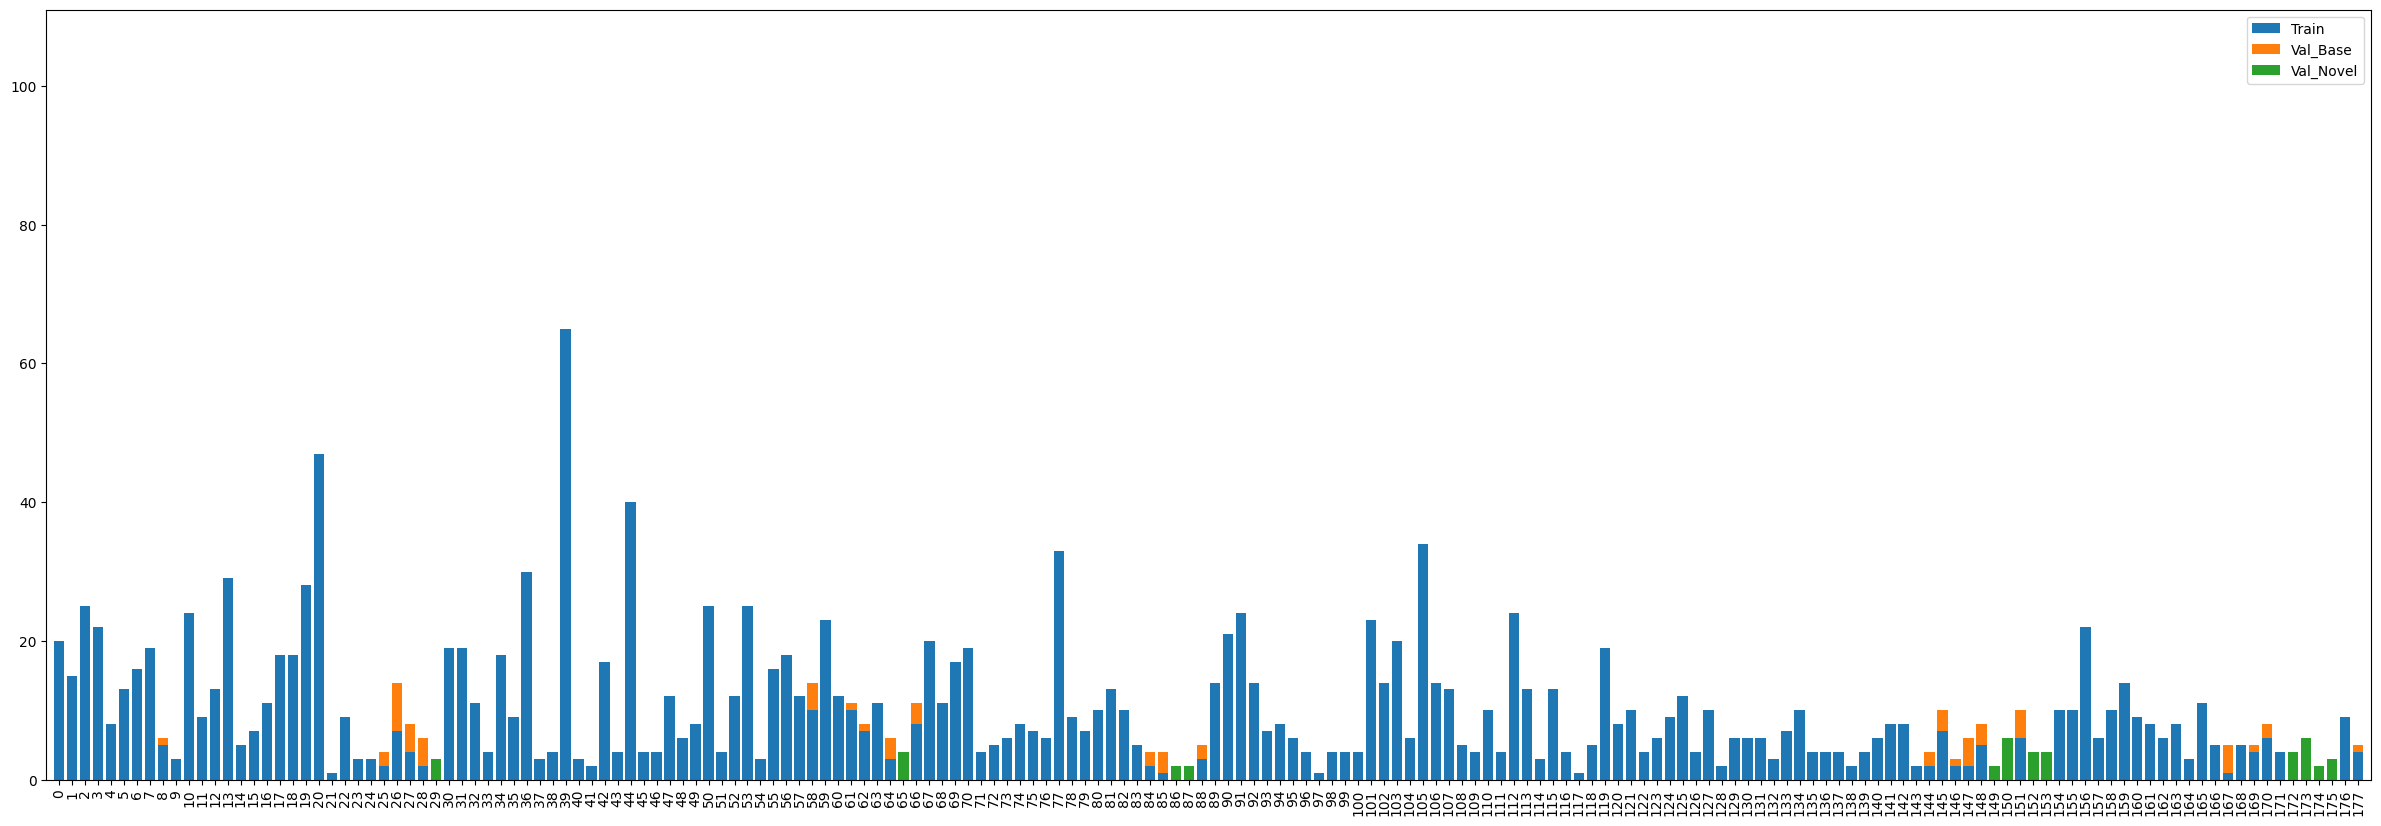

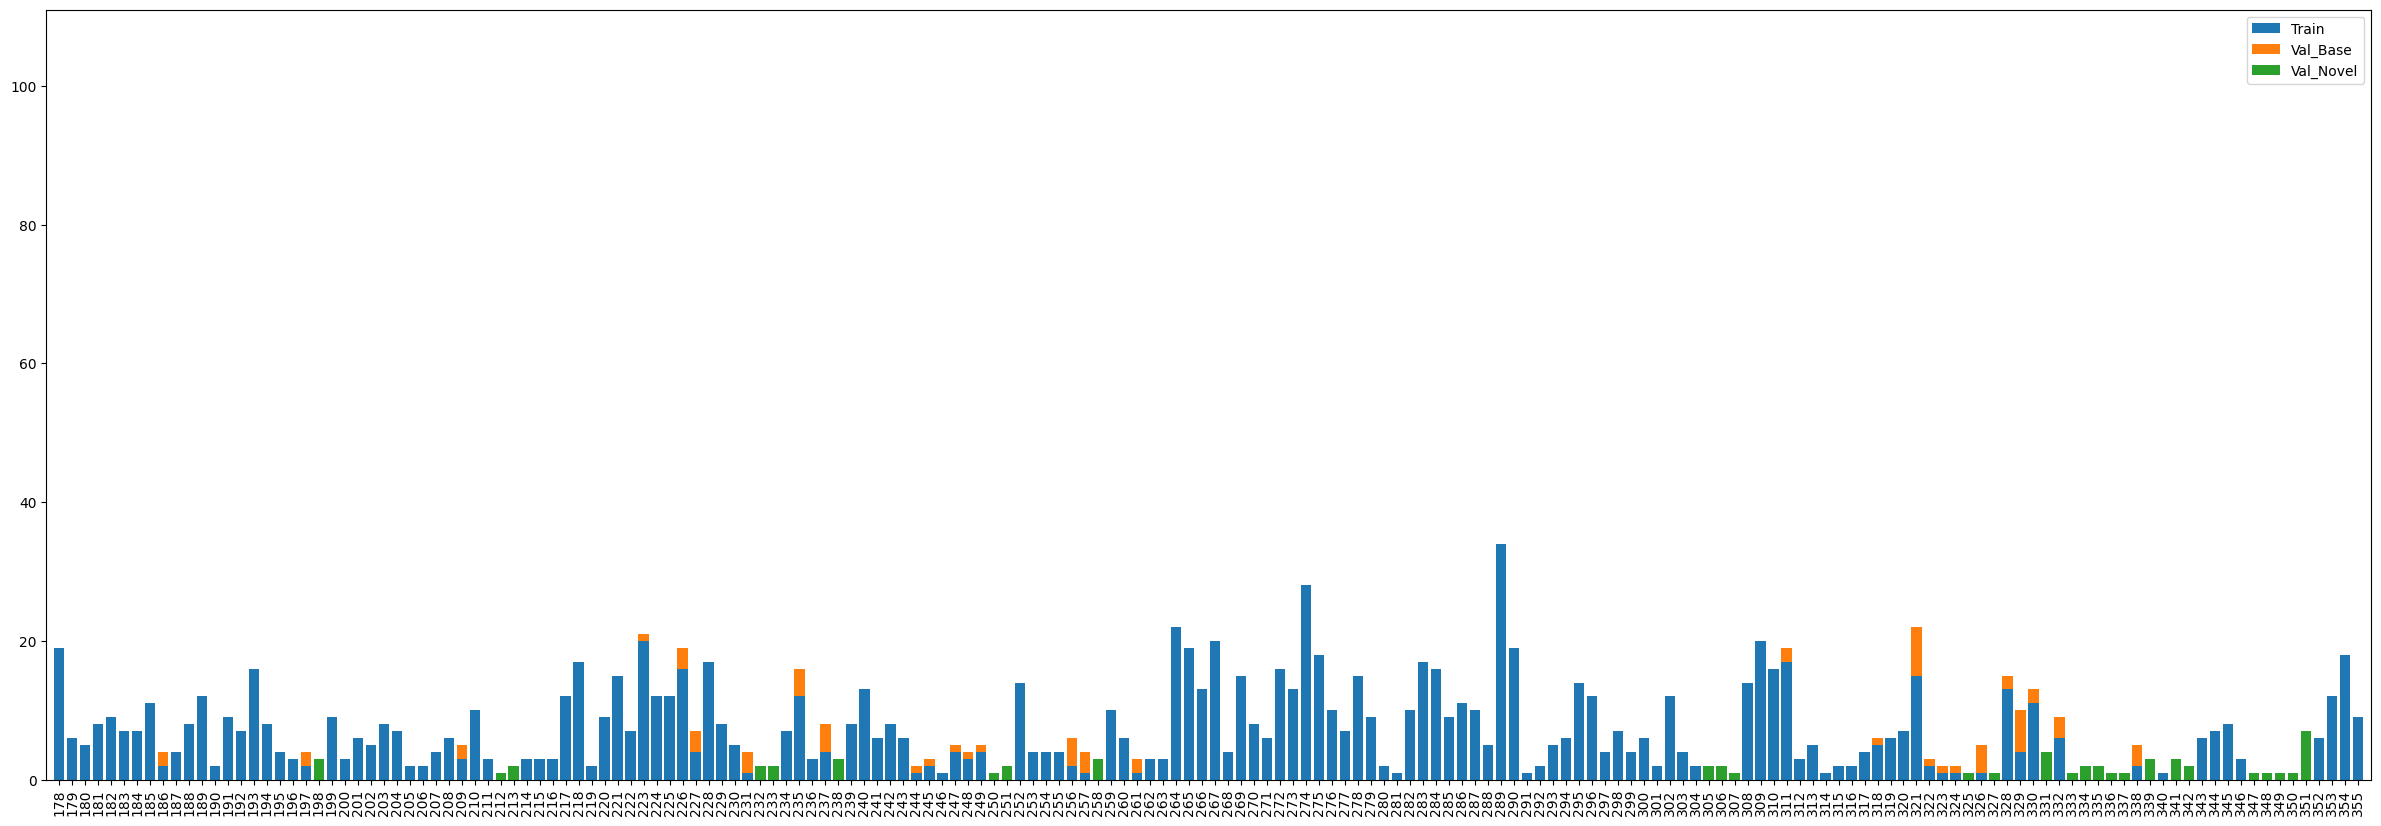

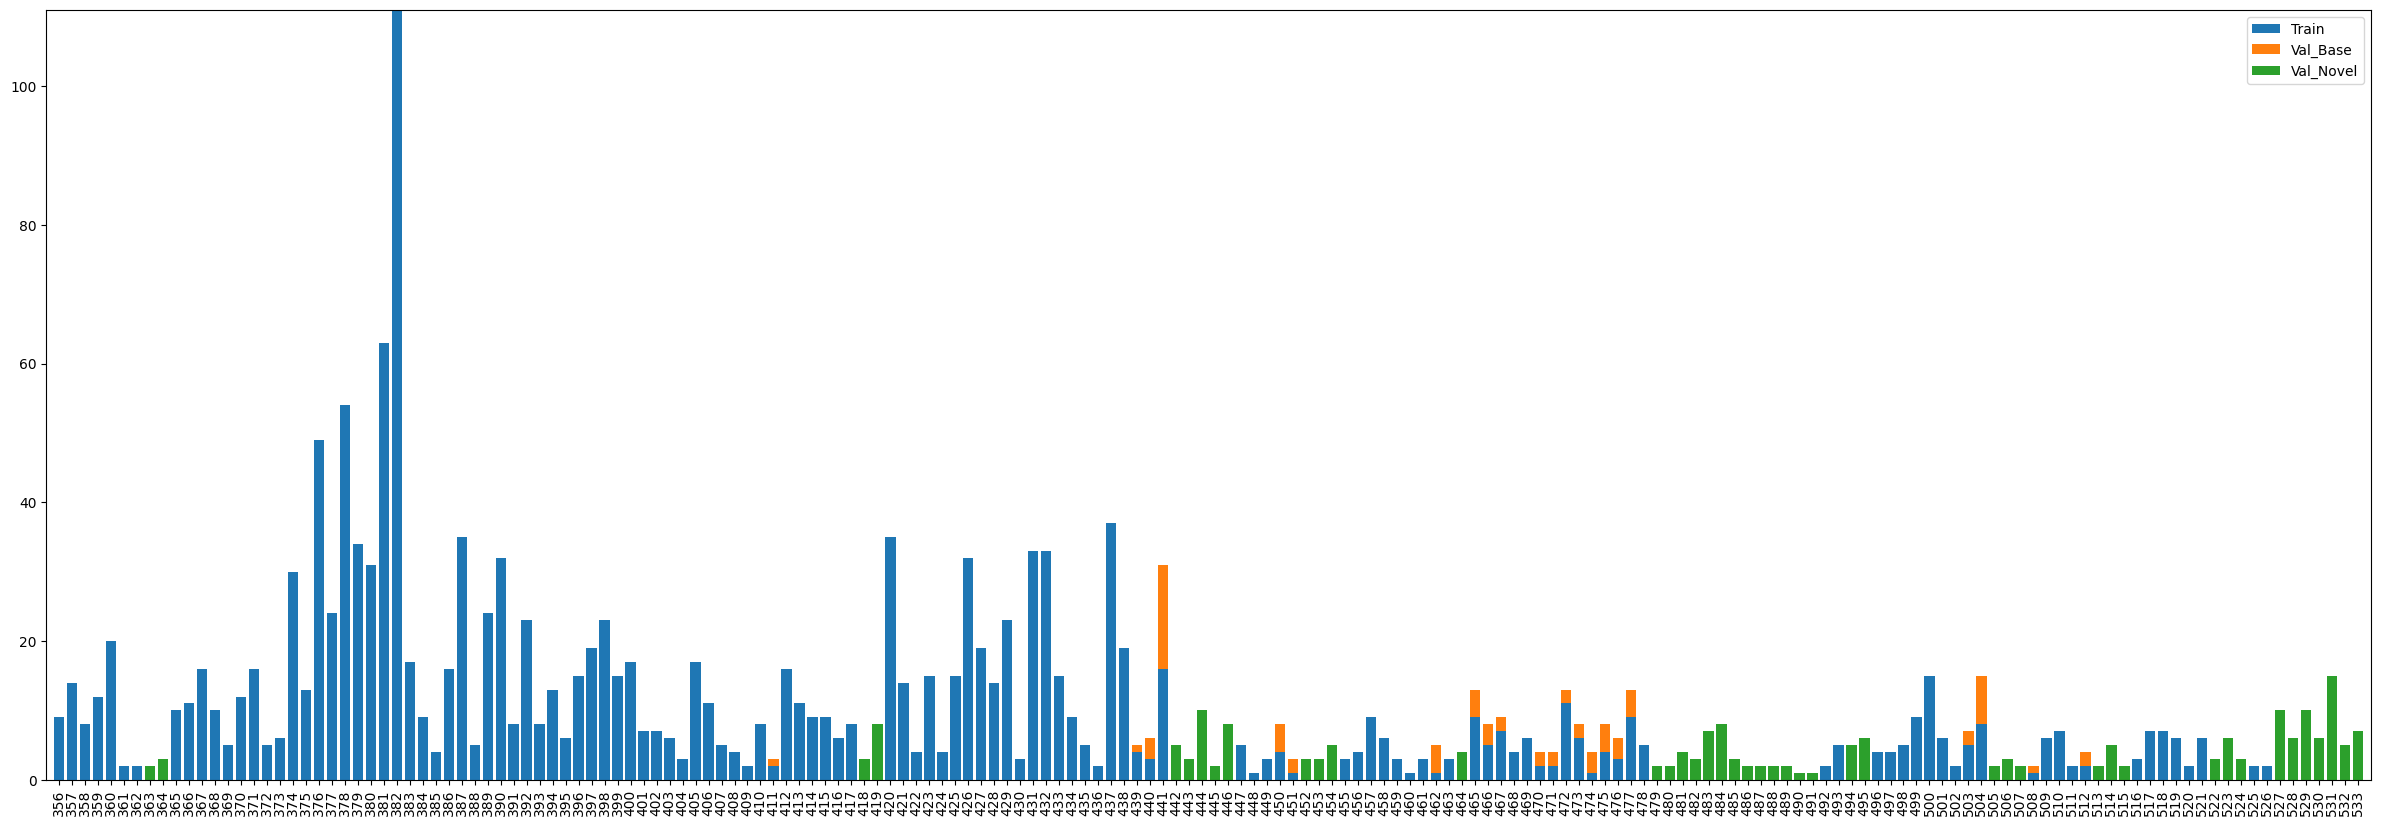

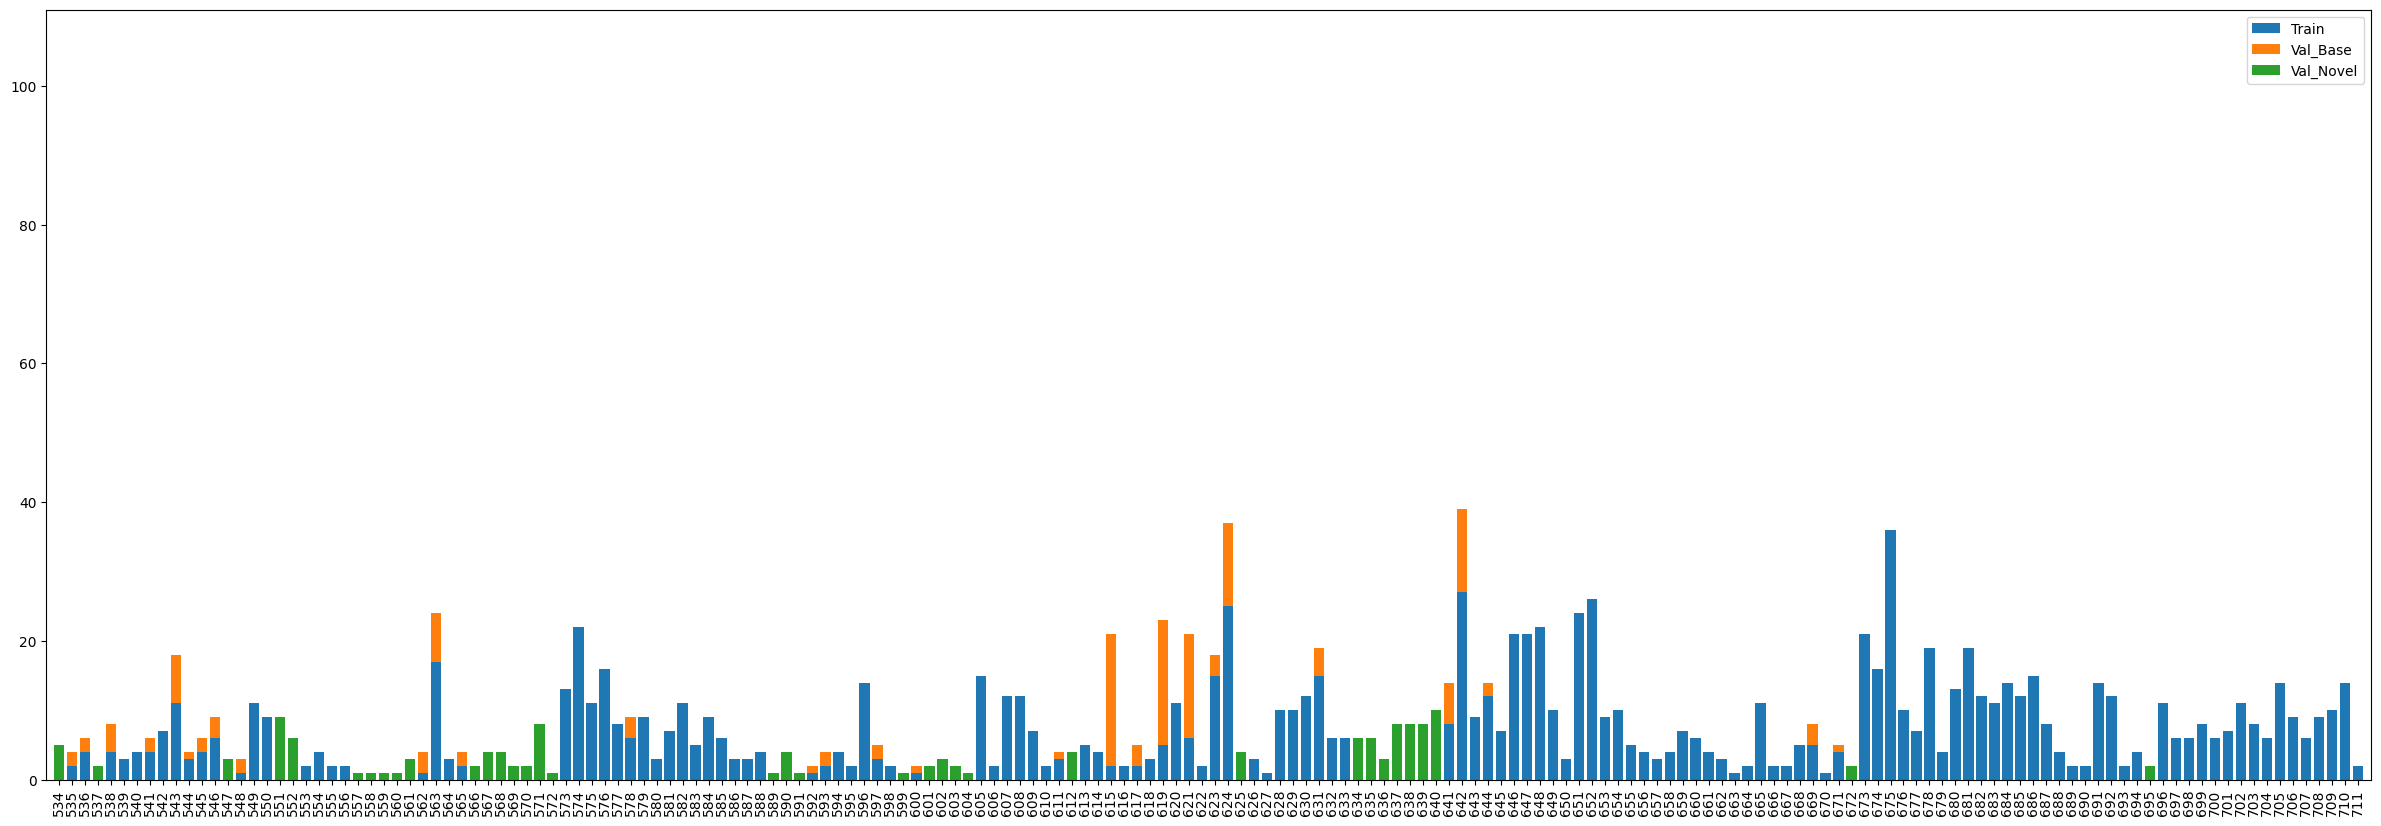

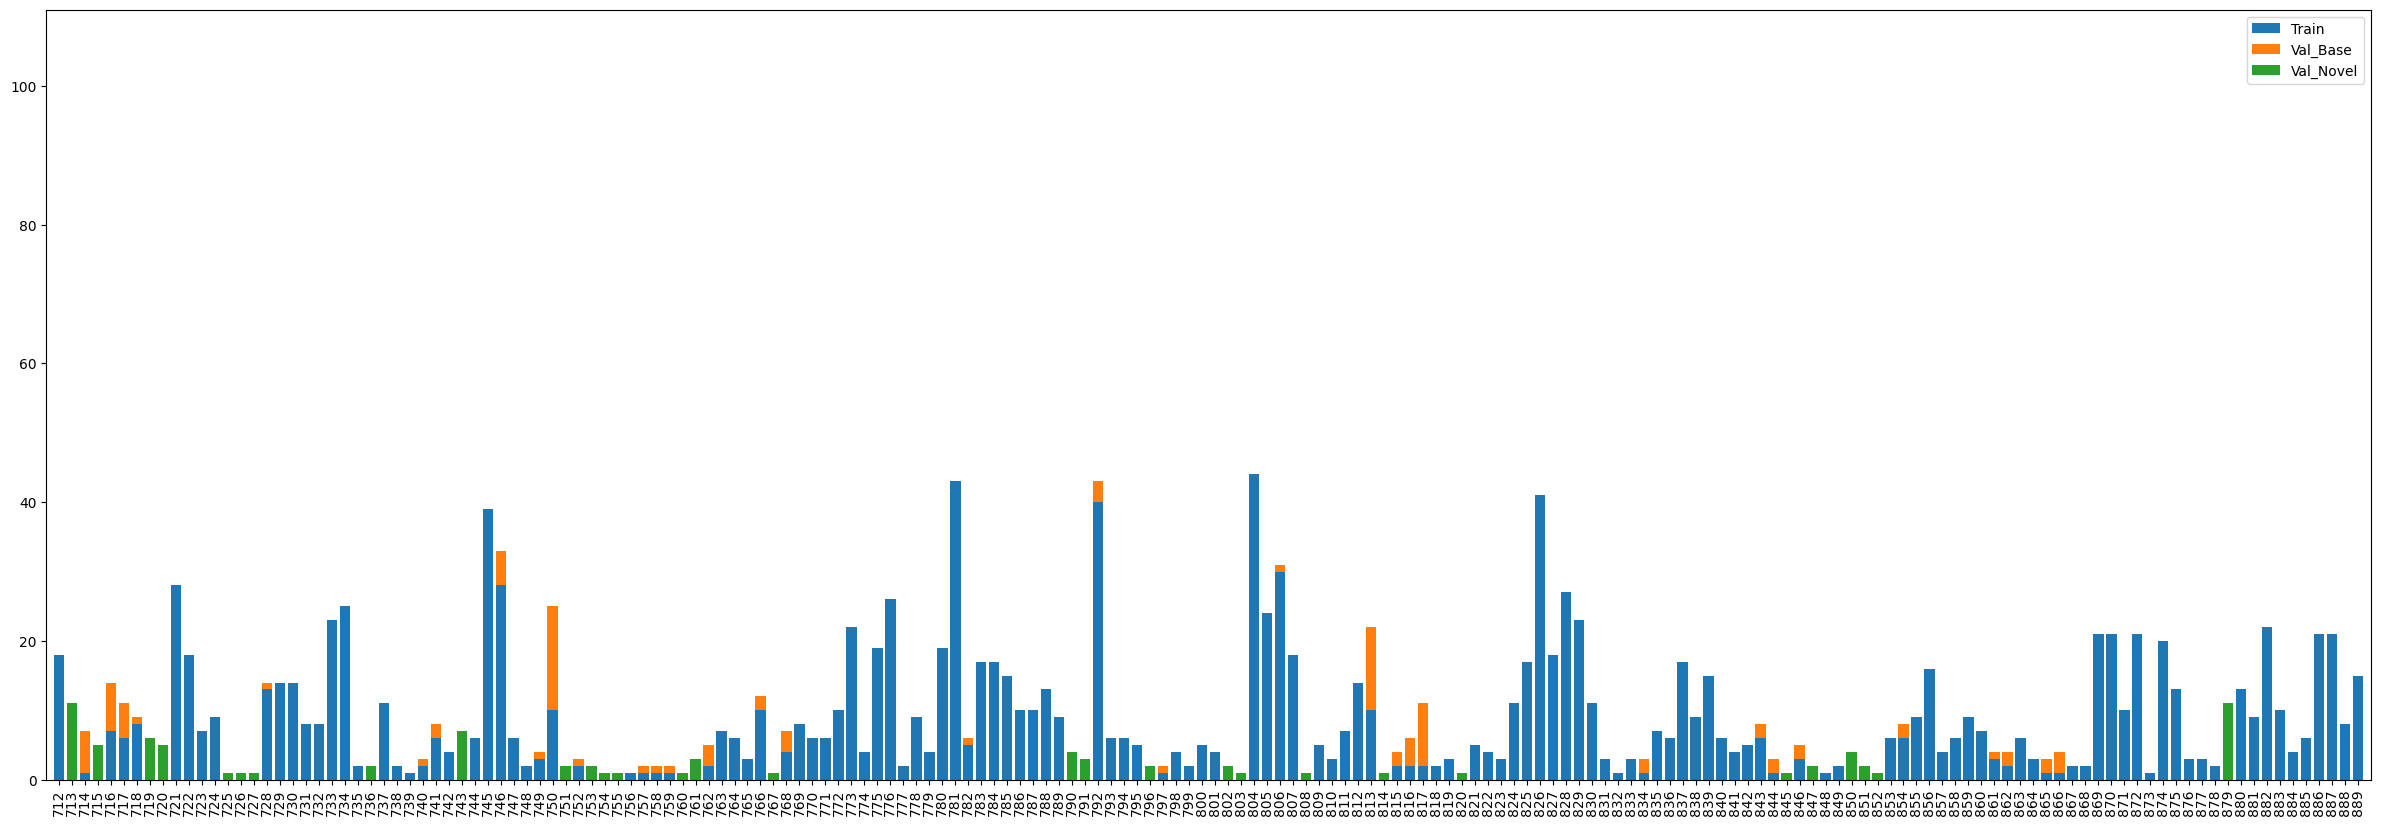

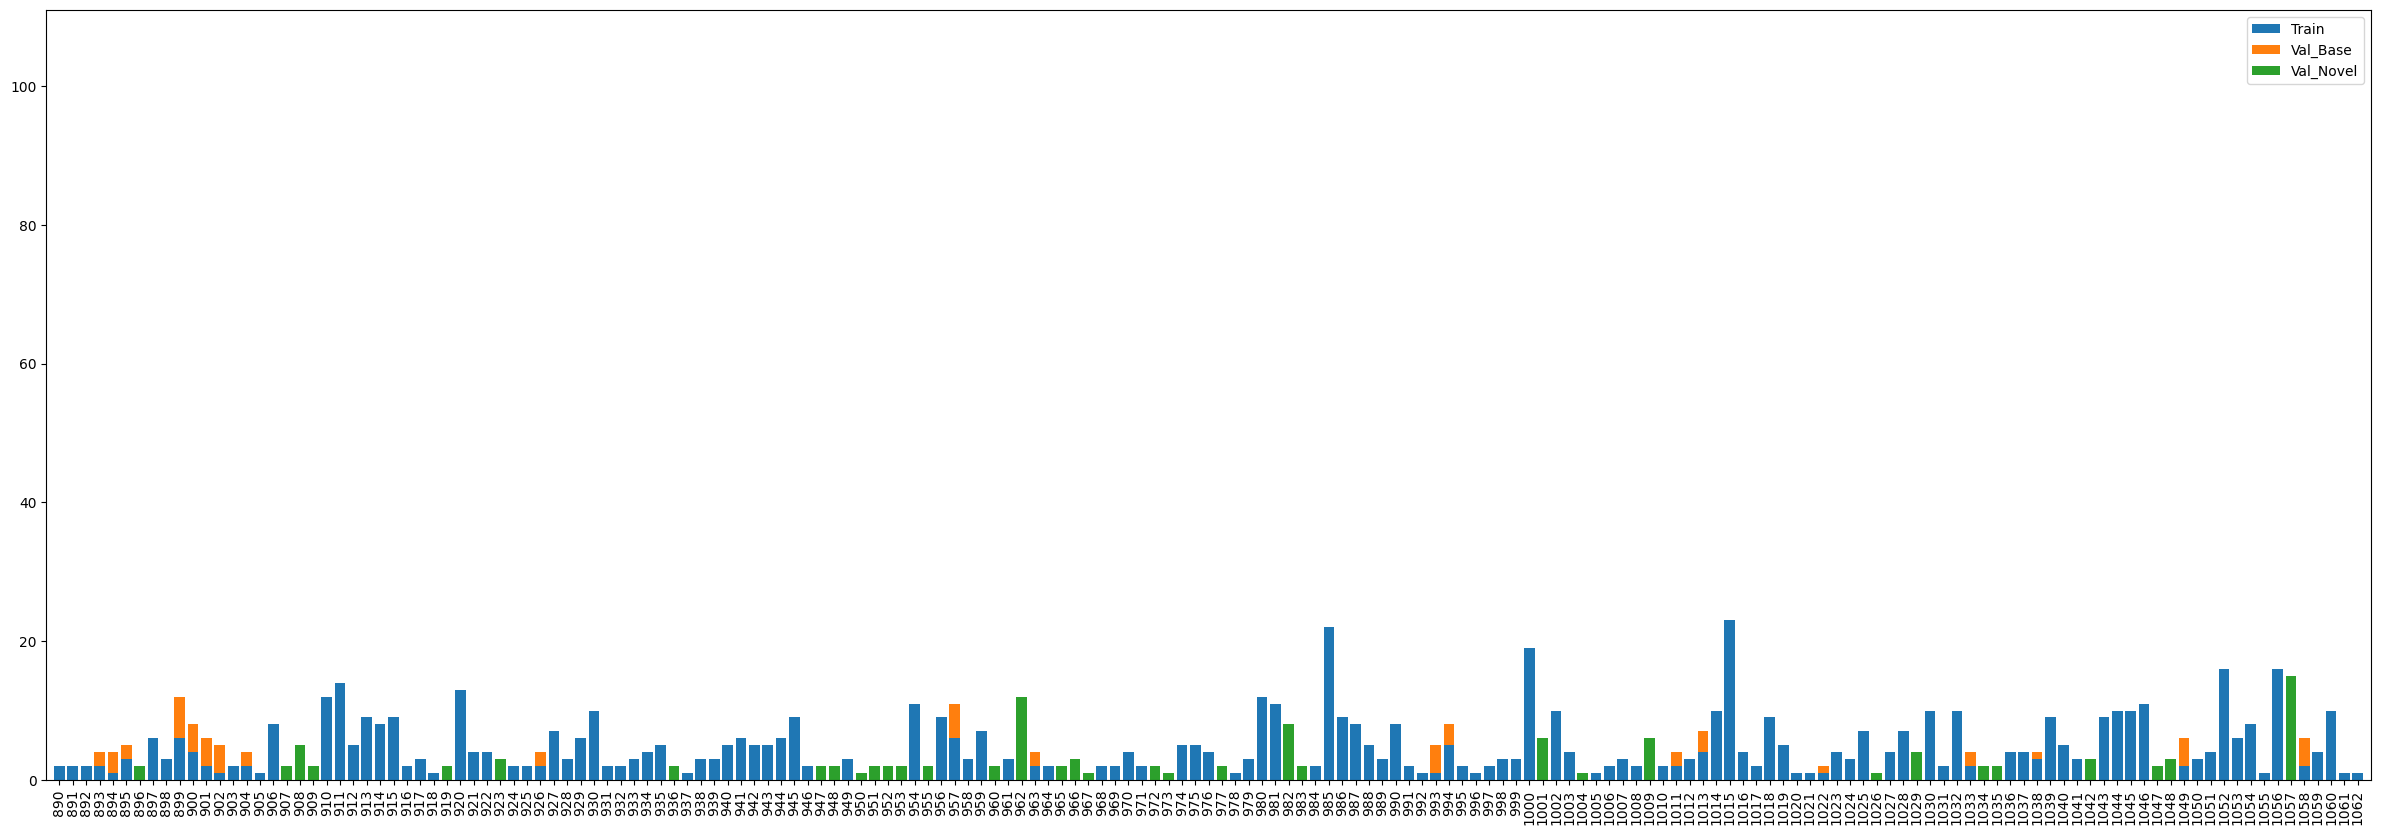

In [23]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_labels(file_paths):
    """Charge les labels de plusieurs fichiers et retourne une DataFrame."""
    labels = []
    for file_path in tqdm(file_paths):
        with open(file_path) as f:
            for line in f:
                labels.append(line.split(" ")[0])
    return pd.DataFrame({"support": labels})

def process_data(train_files, val_files, test_files):
    """Traite les fichiers et retourne un DataFrame combiné."""
    # Charger les données
    aa = load_labels(train_files).astype(int)
    bb = load_labels(val_files).astype(int)
    cc = load_labels(test_files).astype(int)

    # Comptage des valeurs
    counta = aa["support"].value_counts()
    countb = bb["support"].value_counts()
    countc = cc["support"].value_counts()

    # Fusionner les classes uniques
    classes = pd.concat([counta, countb, countc]).index.unique()
    classes = pd.to_numeric(classes).sort_values()

    return classes, counta, countb, countc

def plot_data(classes, counta, countb, countc):
    """Trace les graphiques de type barres empilées."""
    # Diviser les classes en lots
    for i in range(6):
        current_classes = classes[i * 178:(i + 1) * 178]

        # Initialisation des dictionnaires avec 0 pour chaque classe
        listea = {cls: counta.get(cls, 0) for cls in current_classes}
        listeb = {cls: countb.get(cls, 0) for cls in current_classes}
        listec = {cls: countc.get(cls, 0) for cls in current_classes}

        # Créer un DataFrame pour les données de barres empilées
        df = pd.DataFrame({'Train': listea, 'Val': listeb, 'Test': listec}, index=current_classes)
        df = df.sort_index(ascending=True)

        # Créer le graphique
        fig, ax = plt.subplots(figsize=(30, 10))
        ax.bar(df.index, df['Train'], label='Train')
        ax.bar(df.index, df['Val'], bottom=df['Train'], label='Val_Base')
        ax.bar(df.index, df['Test'], bottom=df['Train'] + df['Val'], label='Val_Novel')

        # Ajouter les éléments au graphique
        ax.legend()
        ax.set_xticks(df.index)  # Définir seulement les positions de l'index existant
        ax.set_xticklabels(df.index)  # Utiliser les mêmes valeurs comme étiquettes
        ax.set_xticklabels(df.index, rotation=90)
        ax.set_xlim(min(df.index) - 1, max(df.index) + 1)
        ax.set_ylim(0, max(counta))
        plt.show()

# Main
a = 'labels'
train_files = glob.glob(f'{a}/train/*.txt')
val_files = glob.glob(f'{a}/valid/*.txt')
test_files = glob.glob(f'{a}/test/*.txt')

classes, counta, countb, countc = process_data(train_files, val_files, test_files)
plot_data(classes, counta, countb, countc)